# PINN for Two-Electron Schrödinger Equation Using a Universal Solver

> **Clarification:** This model approximates the *joint* wavefunction ψ(x₁, x₂) using a single network that takes both electron coordinates as input. It simultaneously solves for both electrons, rather than using two separate networks. (one for ecah electron)

This notebook generalizes our `UniversalDESolver` framework to solve the stationary Schrödinger equation for two electrons in one spatial dimension:

$$
-\tfrac12\Bigl(\partial_{x_1}^2 + \partial_{x_2}^2\Bigr)\psi(x_1,x_2)
+ V(x_1,x_2)\,\psi(x_1,x_2) = E\,\psi(x_1,x_2),
$$

with soft-Coulomb potential

$$
V(x_1,x_2) = -\frac{1}{\sqrt{x_1^2 + a^2}} - \frac{1}{\sqrt{x_2^2 + a^2}} + \frac{1}{\sqrt{(x_1 - x_2)^2 + b^2}}.
$$

We treat $\psi: \mathbb{R}^2\to\mathbb{R}$ as the network output and $E$ as a trainable parameter.  Boundary: $\psi=0$ on $x_i=\pm L$.  Normalization: $\int|\psi|^2=1$.

---

## 1. Problem Statement

We consider the stationary Schrödinger equation (atomic units, $\hbar=1, m=1$) for two electrons on a line interacting via a soft Coulomb potential:

$$
-\tfrac12\bigl(\partial_{x_1}^2 + \partial_{x_2}^2\bigr)\psi(x_1,x_2) + V(x_1,x_2)\,\psi(x_1,x_2) = E\,\psi(x_1,x_2),
$$

where the potential is

$$
V(x_1,x_2) = -\frac{1}{\sqrt{x_1^2 + a^2}} - \frac{1}{\sqrt{x_2^2 + a^2}} + \frac{1}{\sqrt{(x_1 - x_2)^2 + b^2}},
$$

with softening parameters $a,b>0$.  We seek the lowest eigenvalue $E$ and the corresponding normalized $\psi(x_1,x_2)$.

**Domain:** $x_1,x_2 \in [-L,L]$ with Dirichlet boundary $\psi=0$ on the edges.

---


## 2. Imports and Setup



In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

---

## 3. PINN Model Definition

We build a network that takes $[x_1,x_2]$ and outputs $\psi$. We also treat the energy $E$ as a trainable parameter.

In [7]:
# Universal solver and sampler with docstrings
defaulE = None
class UniversalDESolver(nn.Module):
    """
    Neural PDE/ODE solver using automatic differentiation.

    Parameters:
    - input_dim: int, number of input coordinates (e.g., 2 for (x1,x2))
    - hidden_dim: int, hidden layer width
    - num_layers: int, number of hidden layers
    - output_dim: int, number of outputs (1 for scalar ψ)
    - activation: callable, activation class (e.g., nn.Tanh)
    """
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim=1, activation=nn.Tanh):
        super().__init__()
        layers = [nn.Linear(input_dim, hidden_dim), activation()]
        for _ in range(num_layers-1):
            layers += [nn.Linear(hidden_dim, hidden_dim), activation()]
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.net = nn.Sequential(*layers)

        self.equation = None      # dict with 'function', 'order', 'params', 'norm_weight'
        self.conditions = []      # list of {'points','function','weight'}
        self.domain = None        # Domain sampler
        # trainable energy parameter (for Schrödinger)
        self.E = nn.Parameter(torch.tensor(1.0))

    def add_equation(self, eq_dict):
        """
        Register PDE residual:
        eq_dict keys:
          'function': callable(pts,psi,grads,d2,E,**params)
          'order': int, highest derivative order
          'params': dict, additional PDE parameters (e.g. a,b for potential)
          'norm_weight': float, weight for normalization loss
        """
        self.equation = eq_dict

    def add_condition(self, cond_dict):
        """
        Add boundary/initial condition:
        cond_dict keys:
          'points': tensor of coords
          'function': target psi value at points
          'weight': float
        """
        self.conditions.append(cond_dict)

    def forward(self, x):
        return self.net(x)

    def compute_residual(self, pts):
        """
        Compute PDE residual at collocation points.
        Returns residual tensor of shape (batch,1).
        """
        pts = pts.clone().requires_grad_(True)
        psi = self(pts)
        grads = torch.autograd.grad(psi, pts,
                                    torch.ones_like(psi),
                                    create_graph=True)[0]
        d2 = None
        if self.equation['order'] >= 2:
            d2x1 = torch.autograd.grad(grads[:,0:1], pts,
                                        torch.ones_like(psi),
                                        create_graph=True)[0][:,0:1]
            d2x2 = torch.autograd.grad(grads[:,1:2], pts,
                                        torch.ones_like(psi),
                                        create_graph=True)[0][:,1:2]
            d2 = torch.cat([d2x1, d2x2], dim=1)
        # call PDE function, include E automatically
        return self.equation['function'](pts, psi, grads, d2, self.E,
                                         **self.equation.get('params', {}))

    def compute_loss(self, batch_size=1024):
        """
        Combined loss: PDE residual + BCs + normalization.
        """
        # PDE residual loss
        f_pts = self.domain.sample_interior(batch_size)
        res = self.compute_residual(f_pts)
        Lf = torch.mean(res**2)
        # boundary conditions
        Lb = torch.tensor(0.0, device=res.device)
        for c in self.conditions:
            pred = self(c['points'])
            targ = c['function'](c['points'])
            Lb = Lb + c.get('weight',1.0)*torch.mean((pred - targ)**2)
        # normalization: ∫|ψ|²=1
        n_pts = self.domain.sample_interior(batch_size)
        norm = torch.mean(self(n_pts)**2)
        Lnorm = (norm - 1.0)**2
        return Lf + Lb + self.equation.get('norm_weight',10.0)*Lnorm

    def train_step(self, optim, batch_size=1024):
        """
        Single optimization step.
        """
        optim.zero_grad()
        loss = self.compute_loss(batch_size)
        loss.backward()
        optim.step()
        return loss.item()


---
### Domain Sampler

In [8]:

class Domain2D:
    """Sampler for 2D square domain [-L,L]^2"""
    def __init__(self, L): self.L = L
    def sample_interior(self, n):
        return (torch.rand(n,2)*2 - 1) * self.L
    def sample_boundary(self, n):
        ne = n//4; L=self.L; edges=[]
        # x1=±L
        edges += [(torch.full((ne,1),-L), torch.rand(ne,1)*2*L-L),
                  (torch.full((ne,1), L), torch.rand(ne,1)*2*L-L)]
        # x2=±L
        edges += [(torch.rand(ne,1)*2*L-L, torch.full((ne,1),-L)),
                  (torch.rand(ne,1)*2*L-L, torch.full((ne,1), L))]
        pts = torch.cat([torch.cat(e,1) for e in edges],0)
        return pts

---
### Define Schrodinger Residual

In [9]:
# potential params
a, b = 0.5, 0.5

def schrodinger_res(pts, psi, grads, d2, E, a, b):
    # grads: [dpsi/dx1, dpsi/dx2]; d2: [d2psi_dx1, d2psi_dx2]
    lap = -0.5*(d2[...,0:1] + d2[...,1:2])
    x1,x2 = pts[:,0:1], pts[:,1:2]
    V = -1/torch.sqrt(x1**2 + a**2) -1/torch.sqrt(x2**2 + a**2)
    V += 1/torch.sqrt((x1-x2)**2 + b**2)
    return lap + V*psi - E*psi

---

## 3. Setup Solver, Conditions, and Training -> should expect -1.5 to -2 a.u for enery
- ### large L, so the true tails of the wavefunction can decay before the boundary

In [17]:
# Instantiate solver
solver = UniversalDESolver(input_dim=2, hidden_dim=128, num_layers=5)
# Register PDE
solver.add_equation({
    'function': schrodinger_res,
    'order':2,
    'params':{'a':a,'b':b},
    'norm_weight':10.0
})
# Domain
domain = Domain2D(L=15.0)  # large enough, so the ground state can be artificially “squeezed,” which raises the energy. 
solver.domain = domain
# Energy parameter inside solver.equation uses model.E
# Boundary: psi=0
b_pts = domain.sample_boundary(2000)
solver.add_condition({
    'points': b_pts,
    'function': lambda x: torch.zeros(x.shape[0],1),
    'weight':1.0
})
# Link energy param
# Monkey-patch residual to read solver.net.E? Instead use solver.net.E
# For brevity, attach E parameter to solver
solver.E = nn.Parameter(torch.tensor(1.0))
solver.net.register_parameter('E', solver.E)

# Optimizer
optim = torch.optim.Adam(solver.net.parameters(), lr=1e-2)
# Training
loss_hist, E_hist = [], []
for epoch in range(5001):
    loss = solver.train_step(optim, batch_size=64)  
    loss_hist.append(loss)
    E_hist.append(solver.E.item())
    if epoch%200==0:
        print(f"Epoch {epoch}: Loss={loss:.2e}, E={solver.E.item():.4f}")

Epoch 0: Loss=9.56e+00, E=0.9900
Epoch 200: Loss=6.67e+00, E=0.1919
Epoch 400: Loss=3.29e+00, E=-0.0476
Epoch 600: Loss=4.24e+00, E=-0.1700
Epoch 800: Loss=6.15e+00, E=-0.0379
Epoch 1000: Loss=2.58e+00, E=-0.3119
Epoch 1200: Loss=3.65e+00, E=-0.3910
Epoch 1400: Loss=1.59e+00, E=-0.4058
Epoch 1600: Loss=2.88e+00, E=-0.3796
Epoch 1800: Loss=1.97e+00, E=-0.3971
Epoch 2000: Loss=1.72e+00, E=-0.3557
Epoch 2200: Loss=1.65e+00, E=-0.3396
Epoch 2400: Loss=9.92e-01, E=-0.3590
Epoch 2600: Loss=9.28e-01, E=-0.3426
Epoch 2800: Loss=1.16e+00, E=-0.3617
Epoch 3000: Loss=6.87e-01, E=-0.3672
Epoch 3200: Loss=1.07e+00, E=-0.3674
Epoch 3400: Loss=6.86e-01, E=-0.3527
Epoch 3600: Loss=7.27e-01, E=-0.3529
Epoch 3800: Loss=1.54e+00, E=-0.3255
Epoch 4000: Loss=1.55e+00, E=-0.3452
Epoch 4200: Loss=6.50e-01, E=-0.3241
Epoch 4400: Loss=5.09e-01, E=-0.2956
Epoch 4600: Loss=4.49e-01, E=-0.3121
Epoch 4800: Loss=1.05e+00, E=-0.3007
Epoch 5000: Loss=7.71e-01, E=-0.2974


---
### Results

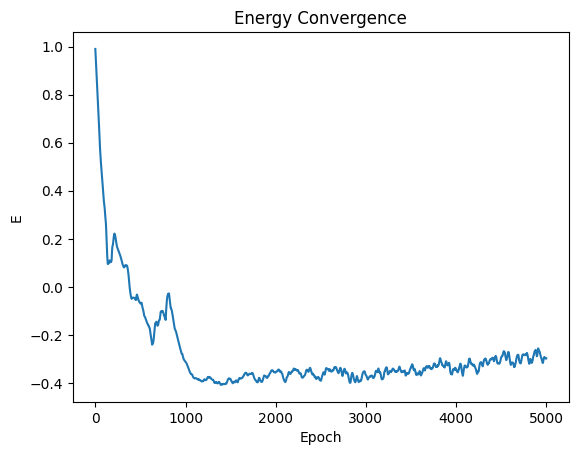

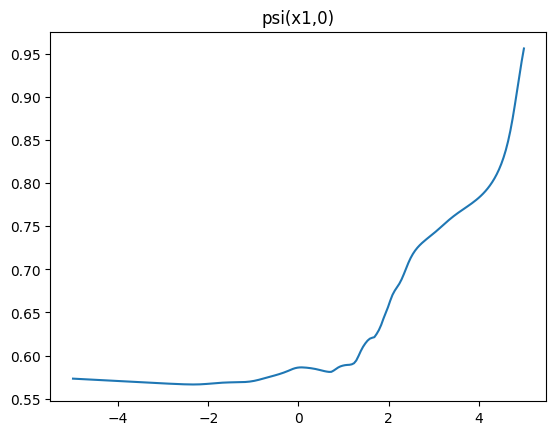

In [18]:
plt.plot(E_hist); plt.title('Energy Convergence'); plt.xlabel('Epoch'); plt.ylabel('E'); plt.show()
# Slice at x2=0
x1 = torch.linspace(-5,5,200).unsqueeze(1)
pts = torch.cat([x1, torch.zeros_like(x1)],1)
with torch.no_grad(): psi_slice = solver(pts).numpy()
plt.plot(x1, psi_slice); plt.title('psi(x1,0)'); plt.show()

---

**Next steps:**
   
- look into giving each electron its own neural network (same if symmetry)
- look into expanding this into n-electron solutions with a more complex potential
